In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop
from keras.utils import image_dataset_from_directory

from tensorflow.keras.applications import EfficientNetB0

from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

2023-11-26 12:43:42.634915: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 12:43:42.927912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 12:43:42.930559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 12:43:44.098596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Specify the path to your image dataset
dataset_training_path = "/home/layth/git/mri_analysis/archive/Training/"
dataset_testing_path = "/home/layth/git/mri_analysis/archive/Testing/"

#dataset_training_path = "/Users/studentuser/WORKING_BASE/mri_analysis/archive/Training"
#dataset_testing_path = "/Users/studentuser/WORKING_BASE/mri_analysis/archive/Testing"

RESIZE = 150
FLAT = RESIZE * RESIZE * 3

In [5]:
# image_size: resizes the images
# batch_size: how many images at a time
# subset: allows me to return a tuple (train_data, val_data)
train_data = image_dataset_from_directory(directory=dataset_training_path,
                                          image_size=(RESIZE, RESIZE),
                                          batch_size=32,
                                          color_mode='rgb',
                                          seed=42)

testing_data = image_dataset_from_directory(directory=dataset_testing_path,
                                          image_size=(RESIZE, RESIZE),
                                          batch_size=32,
                                          color_mode='rgb',
                                          seed=42)


X_train = []
y_train = []
X_test = []
y_test = []

# train_data yields batches. I am 'melting' 
# all batches together in one big array
for images, labels in train_data:
  X_train.extend(images.numpy())
  y_train.extend(labels.numpy())
  
for images, labels in testing_data:
  X_test.extend(images.numpy())
  y_test.extend(labels.numpy())

X_train = np.array(X_train) # convert X_train to numpy array
X_train = np.divide(X_train, 255) # rescale pixels
X_train_flat = X_train.reshape((np.shape(X_train)[0], -1)) # flatten
y_train = np.array(y_train)

X_test = np.array(X_test) # convert X_val to numpy array
X_test = np.divide(X_test, 255) # rescale pixels
X_test_flat = X_test.reshape((np.shape(X_test)[0], -1)) # flatten
y_test = np.array(y_test)

print()
print(f"Flattening after resize: {RESIZE} * {RESIZE} * 3 = {FLAT}")
print(f"Shape of X_train: {np.shape(X_train)}")
print(f"Shape of X_train_flat: {np.shape(X_train_flat)}")
print(f"Shape of y_train: {np.shape(y_train)}")
print(f"Shape of X_test: {np.shape(X_test)}")
print(f"Shape of X_test_flat: {np.shape(X_test_flat)}")
print(f"Shape of y_val: {np.shape(y_test)}")

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.

Flattening after resize: 150 * 150 * 3 = 67500
Shape of X_train: (2870, 150, 150, 3)
Shape of X_train_flat: (2870, 67500)
Shape of y_train: (2870,)
Shape of X_test: (394, 150, 150, 3)
Shape of X_test_flat: (394, 67500)
Shape of y_val: (394,)


In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        self.target_accuracy = target_accuracy
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy so cancelling training!")
            self.model.stop_training = True    

def graph_accuracy_and_loss(history):
  # list all data in history
  # print(history.history.keys())
  
  _, axes = plt.subplots(1, 2, figsize=(20,10))
  
  # summarize history for accuracy
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].set_title('model accuracy')
  axes[0].set_ylabel('accuracy')
  axes[0].set_xlabel('epoch')
  axes[0].legend(['train', 'test'], loc='upper left')
  
  # summarize history for loss
  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].set_title('model loss')
  axes[1].set_ylabel('loss')
  axes[1].set_xlabel('epoch')
  axes[1].legend(['train', 'test'], loc='upper left')
  
  plt.show()
  
  return None

def model_accuracy_and_confusion_matrix(model, Xtrain, ytrain, Xtest, ytest):
  ypred_train        = model.predict(Xtrain)
  ypred_train        = np.argmax(ypred_train, axis=1)
  accuracy_train     = accuracy_score(ytrain, ypred_train)
  conf_matrix_train  = confusion_matrix(ytrain, ypred_train)
  print(f'Accuracy for training data (R^2): {accuracy_train} \n')
  print('Confusion matrix for training data:\n', conf_matrix_train, '\n')

  ypred_test         = model.predict(Xtest)
  ypred_test         = np.argmax(ypred_test, axis=1)
  accuracy_train     = accuracy_score(ytest, ypred_test)
  conf_matrix_train  = confusion_matrix(ytest, ypred_test)
  print(f'Accuracy for testing data (R^2): {accuracy_train} \n')
  print('Confusion matrix for testing data:\n', conf_matrix_train, '\n')
  return None

## Transfer Learning

In [7]:
effnet = EfficientNetB0(weights='imagenet', 
                        include_top=False, 
                        input_shape=(RESIZE,RESIZE,3))

16705208/16705208 [==============================] - 1s 0us/step


In [8]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='linear')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer = RMSprop(learning_rate=0.001), 
              metrics= ['accuracy'])

len(model.layers)

241

In [9]:
EPOCHS=100 # epochs = iterations
BATCH_SIZE=16
TARGET_ACC=0.95
callbacks = myCallback(target_accuracy=TARGET_ACC)
history = model.fit(X_train, y_train,
                    validation_split=.15,
                    callbacks=[callbacks],
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    verbose=1)

print(f"\nYour model reached the desired accuracy after {len(history.epoch)} epochs")

Epoch 1/100


2023-11-26 12:44:20.790659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 658530000 exceeds 10% of free system memory.


153/153 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7839

2023-11-26 12:46:33.690234: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116370000 exceeds 10% of free system memory.


153/153 [==============================] - 137s 819ms/step - loss: 0.5696 - accuracy: 0.7839 - val_loss: 2.6512 - val_accuracy: 0.1369
Epoch 2/100
153/153 [==============================] - 101s 663ms/step - loss: 0.3153 - accuracy: 0.8938 - val_loss: 5.1120 - val_accuracy: 0.1369
Epoch 3/100
153/153 [==============================] - 100s 655ms/step - loss: 0.2045 - accuracy: 0.9389 - val_loss: 10.3536 - val_accuracy: 0.1369
Epoch 4/100
153/153 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9512
Reached 95.0% accuracy so cancelling training!
153/153 [==============================] - 100s 652ms/step - loss: 0.1571 - accuracy: 0.9512 - val_loss: 9.7457 - val_accuracy: 0.1369

Your model reached the desired accuracy after 4 epochs


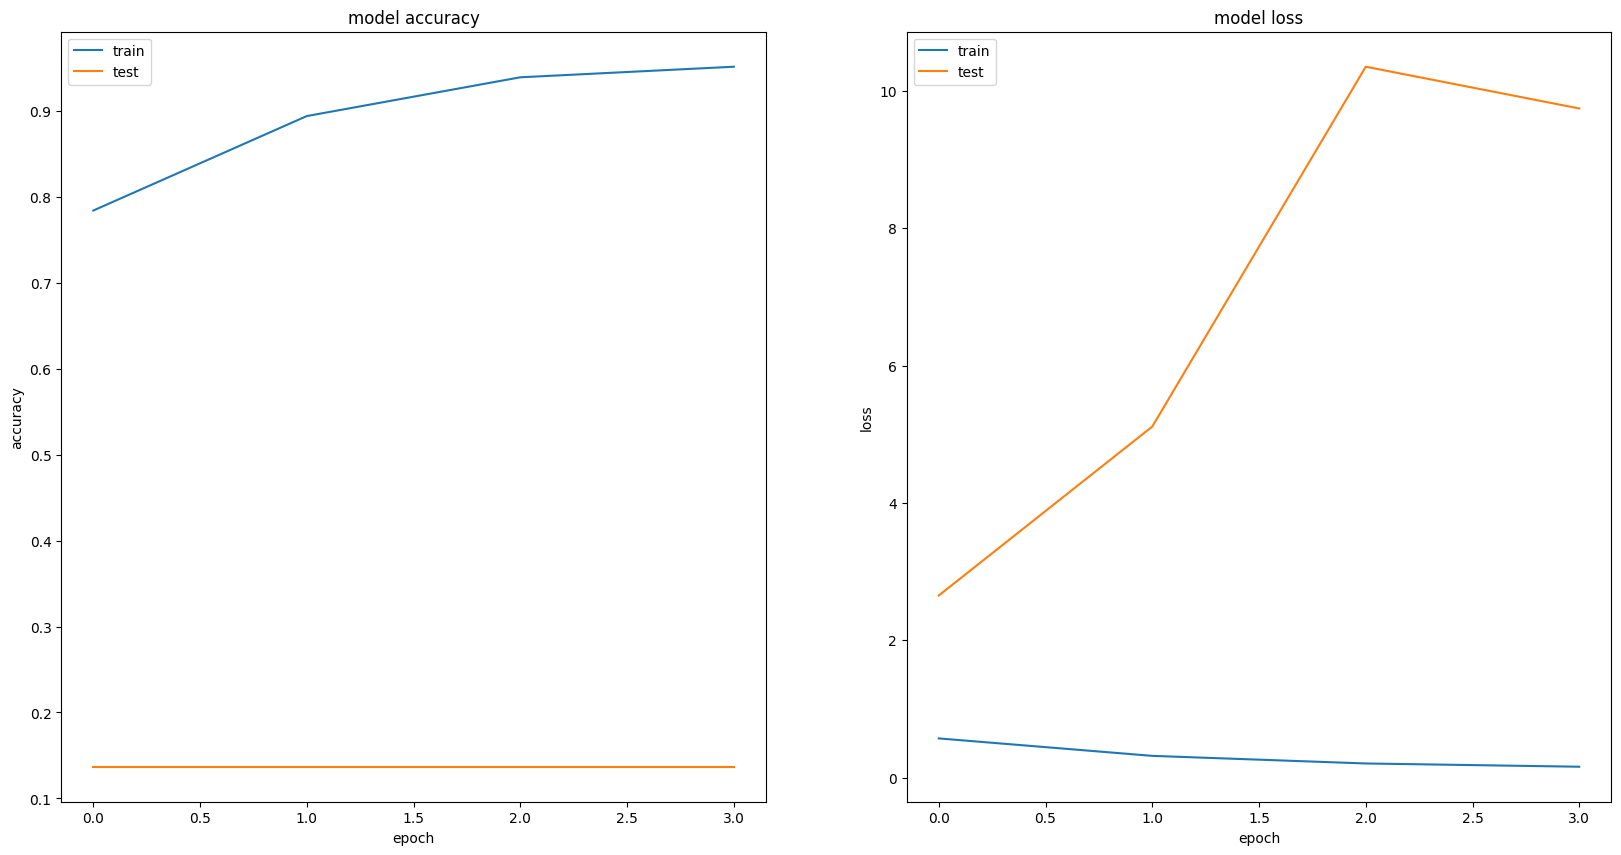

2023-11-26 12:52:48.235938: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 774900000 exceeds 10% of free system memory.
2023-11-26 12:52:50.085729: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69120000 exceeds 10% of free system memory.
2023-11-26 12:52:50.099706: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 69120000 exceeds 10% of free system memory.


90/90 [==============================] - 26s 277ms/step
Accuracy for training data (R^2): 0.13763066202090593 

Confusion matrix for training data:
 [[  0   0 826   0]
 [  0   0 822   0]
 [  0   0 395   0]
 [  0   0 827   0]] 

13/13 [==============================] - 3s 262ms/step
Accuracy for testing data (R^2): 0.26649746192893403 

Confusion matrix for testing data:
 [[  0   0 100   0]
 [  0   0 115   0]
 [  0   0 105   0]
 [  0   0  74   0]] 



In [10]:
graph_accuracy_and_loss(history=history)
model_accuracy_and_confusion_matrix(model, X_train, y_train, X_test, y_test)